Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [69]:
import numpy as np
import requests

API_KEY = 'ei_9dc018ebbef6ea2aaabf980a29745a066ef4fa823a9e196184e8ab42771c9fb4'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/42476/training/9/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/42476/training/9/y')


Store the data in a temporary file, and load it back through Numpy.

In [70]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [71]:
X.shape, Y.shape

((107, 9216), (107,))

In [72]:
set(Y)

{1, 2, 3}

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

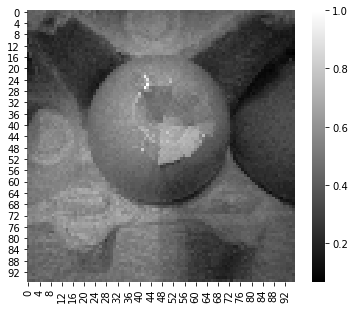

In [74]:
image = X[90]
image = np.reshape(image, (96, 96))
plt.figure(figsize=(6,5));
sns.heatmap(image, cmap='gray');

Define our labels and split the data up in a test and training set:

In [75]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cracked", "empty", "intact" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Train the model:

In [76]:
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy

WEIGHTS_PATH = './transfer-learning-weights/edgeimpulse/MobileNetV2.0_35.96x96.grayscale.bsize_64.lr_0_005.epoch_260.val_loss_3.10.val_accuracy_0.35.hdf5'
# Download the model weights
root_url = 'http://cdn.edgeimpulse.com/'
p = Path(WEIGHTS_PATH)
if not p.exists():
    if not p.parent.exists():
        p.parent.mkdir(parents=True)
    weights = requests.get(root_url + WEIGHTS_PATH[2:]).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights)

INPUT_SHAPE = (96, 96, 1)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = INPUT_SHAPE, alpha=0.35,
    weights = WEIGHTS_PATH
)


In [77]:
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   144         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 16)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [ ]:
base_model.save('saved_base_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [78]:
base_model.trainable = False

model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))
# Don't include the base model's top layers
last_layer_index = -3
model.add(Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 3, 3, 1280)        409920    
_________________________________________________________________
dense_10 (Dense)             (None, 3, 3, 16)          20496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 435       
Total params: 430,851
Trainable params: 20,931
Non-trainable params: 409,920
_________________________________________________________________


In [79]:
# Set the data to the expected input shape
train_dataset = train_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)

# Implements the data augmentation policy
def augment_image(image, label):
    # Flips the image randomly
    image = tf.image.random_flip_left_right(image)

    # Increase the image size, then randomly crop it down to
    # the original dimensions
    resize_factor = random.uniform(1, 1.2)
    new_height = math.floor(resize_factor * INPUT_SHAPE[0])
    new_width = math.floor(resize_factor * INPUT_SHAPE[1])
    image = tf.image.resize_with_crop_or_pad(image, new_height, new_width)
    image = tf.image.random_crop(image, size=INPUT_SHAPE)

    # Vary the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, label

train_dataset = train_dataset.map(augment_image, tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [80]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=20, 
                    verbose=2, 
                    callbacks=callbacks)

print('')
print('Initial training done.', flush=True)

Epoch 1/20
3/3 - 4s - loss: 1.2242 - accuracy: 0.4118 - val_loss: 0.6396 - val_accuracy: 0.7727
Epoch 2/20
3/3 - 0s - loss: 0.7888 - accuracy: 0.6000 - val_loss: 0.4710 - val_accuracy: 0.9545
Epoch 3/20
3/3 - 0s - loss: 0.6237 - accuracy: 0.8471 - val_loss: 0.3624 - val_accuracy: 0.9545
Epoch 4/20
3/3 - 0s - loss: 0.4586 - accuracy: 0.8824 - val_loss: 0.2761 - val_accuracy: 0.9545
Epoch 5/20
3/3 - 0s - loss: 0.3083 - accuracy: 0.9412 - val_loss: 0.2109 - val_accuracy: 0.9545
Epoch 6/20
3/3 - 0s - loss: 0.2795 - accuracy: 0.9176 - val_loss: 0.1567 - val_accuracy: 0.9545
Epoch 7/20
3/3 - 0s - loss: 0.2026 - accuracy: 0.9529 - val_loss: 0.1003 - val_accuracy: 1.0000
Epoch 8/20
3/3 - 0s - loss: 0.1696 - accuracy: 0.9529 - val_loss: 0.0662 - val_accuracy: 1.0000
Epoch 9/20
3/3 - 0s - loss: 0.0956 - accuracy: 0.9765 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 10/20
3/3 - 0s - loss: 0.0609 - accuracy: 0.9882 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 11/20
3/3 - 0s - loss: 0.0669 - a

In [60]:
def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show() 

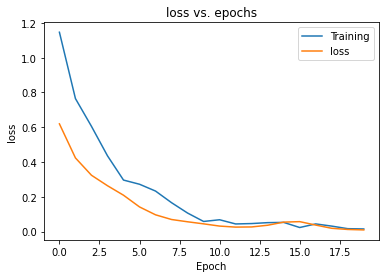

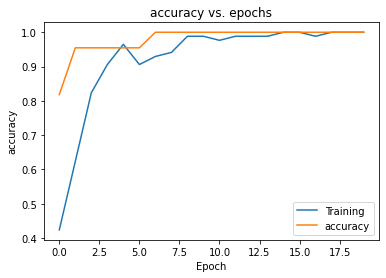

In [61]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [81]:
# How many epochs we will fine tune the model
FINE_TUNE_EPOCHS = 10
# What percentage of the base model's layers we will fine tune
FINE_TUNE_PERCENTAGE = 65

print('Fine-tuning model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# Determine which layer to begin fine tuning at
model_layer_count = len(model.layers)
fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# Allow the entire base model to be trained
model.trainable = True
# Freeze all the layers before the 'fine_tune_from' layer
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset,
                epochs=FINE_TUNE_EPOCHS,
                verbose=2,
                validation_data=validation_dataset,
                callbacks=callbacks)


Fine-tuning model for 10 epochs...
Epoch 1/10
3/3 - 4s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 2/10
3/3 - 0s - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 3/10
3/3 - 0s - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 4/10
3/3 - 0s - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 5/10
3/3 - 0s - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 6/10
3/3 - 0s - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 7/10
3/3 - 0s - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 8/10
3/3 - 0s - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 9/10
3/3 - 0s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 10/10
3/3 - 0s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000


In [82]:
# Save the model to disk
model.save('saved_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/assets


## TensorFlow Lite - Micro

In [84]:
TF_MODEL = 'saved_model'
TFLITE_MODEL = 'saved_model.tflite'
TFLITE_MICRO_MODEL = 'saved_model.cc'

In [ ]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_egg_detection = load_model(TF_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model_egg_detection)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open(TFLITE_MODEL,"wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

### Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [ ]:
!apt-get update && apt-get -qq install xxd

In [87]:
!xxd -i {TFLITE_MODEL} > {TFLITE_MICRO_MODEL}
REPLACE_TEXT = TFLITE_MODEL.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {TFLITE_MICRO_MODEL}

If you'd like to download your model for safekeeping:
1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```model_mask_detection.cc``` file and select download

Note that the model is too big to be used on an Arduino NANO, as we expected. 

In [88]:
!cat {TFLITE_MICRO_MODEL}

Streaming output truncated to the last 5000 lines.
  0xd8, 0xd6, 0xe6, 0xf6, 0x34, 0xe7, 0x37, 0x04, 0xfb, 0xfb, 0x38, 0x32,
  0xf5, 0x99, 0xfd, 0x0a, 0xd3, 0xf2, 0xdf, 0x46, 0x2d, 0x2c, 0x22, 0xe9,
  0x0c, 0xff, 0x0a, 0x3a, 0x07, 0x05, 0xaa, 0xa4, 0x07, 0xe5, 0x00, 0x00,
  0xd7, 0xe5, 0xf3, 0xb1, 0xdf, 0xe0, 0x15, 0xd3, 0xdd, 0xcd, 0x42, 0x21,
  0xf7, 0x0f, 0x12, 0xb2, 0xa1, 0x1a, 0x14, 0x28, 0x4c, 0xb0, 0xd5, 0xd6,
  0xd1, 0xf1, 0xf8, 0xce, 0xec, 0x25, 0x68, 0xf1, 0x21, 0xec, 0x45, 0x21,
  0x4b, 0xe6, 0xf9, 0x1c, 0xff, 0x09, 0xe2, 0x33, 0xc6, 0x0e, 0x0a, 0x81,
  0x2f, 0xde, 0x33, 0x07, 0x27, 0x0e, 0xff, 0xc1, 0xff, 0xd2, 0xea, 0xc8,
  0x01, 0xed, 0x03, 0xe8, 0x38, 0xac, 0x38, 0xf3, 0xe5, 0xd7, 0x48, 0x0f,
  0xb0, 0x27, 0x1c, 0xf2, 0xa3, 0x0b, 0xf6, 0x31, 0xce, 0xcc, 0xf2, 0x28,
  0xfd, 0x9e, 0x52, 0xeb, 0xa1, 0x2e, 0xf4, 0x23, 0xf5, 0xc4, 0x0d, 0xe4,
  0x62, 0x51, 0xc4, 0x4f, 0x2d, 0x35, 0x4b, 0x54, 0xe5, 0x15, 0xed, 0x06,
  0x13, 0x47, 0x19, 0x37, 0x3a, 0x13, 0xd0, 0x04, 0xf5, 0x3a,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00,
  0x61, 0x79, 0xaf, 0x3b, 0x64, 0xfc, 0x16, 0x3c, 0x6e, 0xfd, 0x17, 0x3c,
  0x86, 0x7e, 0x49, 0x3c, 0x64, 0x07, 0x54, 0x3c, 0x1d, 0xab, 0x22, 0x3c,
  0x73, 0x4c, 0x01, 0x3c, 0xa0, 0xa5, 0x37, 0x3c, 0x50, 0xb7, 0x12, 0x3c,
  0xb2, 0xd3, 0x44, 0x3c, 0x62, 0xc9, 0x7f, 0x3c, 0x99, 0x72, 0x18, 0x3c,
  0xb9, 0x3c, 0x97, 0x3b, 0x97, 0x61, 0x19, 0x3c, 0xf8, 0x66, 0x2c, 0x3c,
  0x7d, 0x50, 0xe3, 0x3b, 0xac, 0x75, 0xa4, 0x3b, 0x61, 0x6b, 0x9b, 0x3b,
  0xde, 0x11, 0xaf, 0x3b, 0x67, 0x69, 0x38, 0x3c, 0xc8, 0x4f, 0x8b, 0x3b,
  0xfe, 0x4d, 0x81, 0x3b, 0x64, 0x7b, 0x73, 0x3c, 0x7d, 0x3a, 0x90, 0x3b,
  0x87, 0x39, 0x14, 0x3c, 0x77, 0x9c, 0x1d, 0x3c, 0x94, 0x4d, 0x77, 0x3b,
  0x5d,